# StackOverflow Tags Prediction without specific packagess

# Outline
- [ 1 - Import the Data](#1)
- [ 2 - Exploring the Data](#2)
  - [ 2.1 - Bag of words](#2.1)
  - [ 2.2 - TF-IDF](#2.2)
  - [ 2.3 - CBOW](#2.3)
    - [ 2.3.1 - Data prepare](#2.3.1)
    - [ 2.3.2 - Train neuron network](#2.3.2)
    - [ 2.3.3 - PCA for plotting results](#2.3.3)
- [ 3 - Model creation and evaluation](#3)
    - [ 3.1 - BOW model](#3.1)
    - [ 3.2 - TFIDF model](#3.2)
    - [ 3.3 - CBOW model](#3.3)    
    

<a name="1"></a>
## 1 - Import the Data

TO DO!!!!

In this section, you will use [`Kaggle Questions csv file`](https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/input?select=Questions.csv) to transform the sentences into integers, so they can be fed into the model you will build later on.
[`Kaggle Labled Tags csv file`](https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/input?select=Tags.csv)

In [191]:
import numpy as np
import pandas as pd
from scipy import sparse as sp_sparse
import re
from numpy import linalg as LA
from ast import literal_eval

In [193]:
train = pd.read_csv('/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Questions.csv/Questions.csv',\
                    encoding = "ISO-8859-1", nrows=100000,index_col=False)

In [195]:
y_data = pd.read_csv('/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Tags.csv/Tags_1.csv',\
                     encoding = "ISO-8859-1",index_col=False)

In [113]:
all_data = pd.concat([train, y_data], axis=1)

<a name="2"></a>
## 2 - Exploring the Data and prepare data for model

In [117]:
all_data.head()

,title,tags
0,How to draw a stacked dotplot in R?,['r']
1,mysql select all records where a datetime fiel...,"['php', 'mysql']"
2,How to terminate windows phone 8.1 app,['c#']
3,get current time in a specific country via jquery,"['javascript', 'jquery']"
4,Configuring Tomcat to Use SSL,['java']


In [115]:
len(all_data)

100000

In [197]:
all_data['tags'] = all_data['tags'].apply(literal_eval)

In [201]:
%matplotlib inline
import matplotlib.pyplot as plt

In [203]:
def most_common_words(text):
    words_counts = {}

    for i in text:
        try:
            for j in i.split():
                words_counts[j] = words_counts.get(j, 0) + 1
        except:
            for j in i:
                words_counts[j] = words_counts.get(j, 0) + 1
    return words_counts

words_counts = most_common_words(all_data["tags"])
words_counts = dict(sorted(words_counts.items(), key=lambda x: x[1], reverse=True))

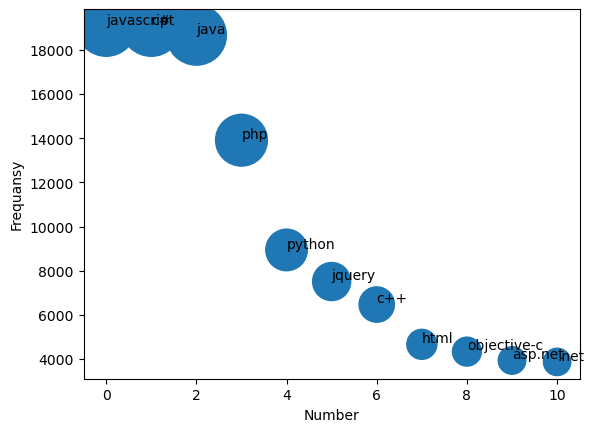

In [205]:
max_words = 11
x = range(max_words)
y = list(words_counts.values())[:max_words]
z = [i/10 for i in list(words_counts.values())[:max_words]]

fig, ax = plt.subplots()

ax.set_xlabel("Number")
ax.set_ylabel("Frequansy")
    
ax.scatter(x, y, s=z)

for i, txt in enumerate(list(words_counts.keys())[:max_words]):
    ax.annotate(txt, (x[i], y[i]+100))


plt.show()

In [221]:
def train_test_splitting(X, y, test_size, shuffle=True):
    length_data = len(X)
    test_len = int(length_data*test_size)
    train_len = length_data - test_len
    if shuffle:
        index = np.random.permutation(length_data)
    else:
        index = np.arange(length_data)
    train_index = index[:train_len]
    test_index = index[train_len:]

    return X[train_index],X[test_index],y[train_index],y[test_index]

In [223]:
np.random.seed(0)
X_train,X_test,y_train,y_test = train_test_splitting(all_data["title"], all_data["tags"], test_size=0.3 , shuffle=True) 

In [217]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeiakhmadulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [225]:
def text_prepare(text):
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower()

    text = REPLACE_BY_SPACE_RE.sub(r' ',text)
    text = BAD_SYMBOLS_RE.sub(r'',text)
    text = [w for w in text.split() if not w in STOPWORDS]
    
    return ' '.join(text)

In [227]:
X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]

<a name="2.1"></a>
## 2.1 - Bag of words

In [229]:
import Bagofwords as BOW

BagOW = BOW.BagOfWords(maximum_words = 5000)
BagOW.fit(X_train)
X_train_mybag = BagOW.transform(X_train)
X_test_mybag = BagOW.transform(X_test)
bag_of_words_dic = BagOW.get_vocab()

In [231]:
X_train_mybag

<70000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 360175 stored elements in List of Lists format>

<a name="2.2"></a>
## 2.2 - TF-IDF

 For this approuch we'll create module Tfidf that create a class and make fit, transform tramsformation

In [233]:
import Tfidf as tf

tfidf_obj = tf.TFIDF()
tfidf_obj.fit(X_train)

X_train_tfidf = tfidf_obj.transform(X_train)
X_test_tfidf = tfidf_obj.transform(X_test)
tfidf_vocab = tfidf_obj.get_vocab()

tfidf_index_to_word = {word[0]:index for index,word in enumerate(tfidf_vocab)}

/Users/sergeiakhmadulin/My Drive/Simple NLP/Tfidf.py:43: RuntimeWarning: divide by zero encountered in divide
  norm_tfidf = tfidf.multiply(1/np.sqrt(np.sum(tfidf.power(2), axis = 1)).reshape((length_rows,1)))


In [235]:
X_train_tfidf

<70000x25420 sparse matrix of type '<class 'numpy.float64'>'
	with 389409 stored elements in COOrdinate format>

<a name="2.3"></a>
## 2.3 - CBOW

 For this approuch we'll create two dictionaries to convert all unick words into a number and vise versa. Next we'll create two arres one with context words and another with center, that is what we are going to feed into neuron network. Train simple neuron networt with only 2 layers. As a result we'll get two matrises with trained weights the mean sum of them give us embedings of each word.

<a name="2.3.1"></a>
### 2.3.1 - Data prepare

In [237]:
def add_pad(text, num_of_padding, padding_car):
    text_with_pad = []
    for sent in text:
        sent = (padding_car + " ") * num_of_padding + sent + (" " + padding_car) * num_of_padding
        text_with_pad.append(sent)
    return text_with_pad

In [239]:
def get_dict(text): 
    idx = 0
    word2Ind = {}
    Ind2word = {}
    for sent in text:
        try:
            for word in sent.split():
                if word not in word2Ind.keys():
                    word2Ind[word] = idx
                    Ind2word[idx] = word
                    idx += 1
        except:
            for word in sent:
                if word not in word2Ind.keys():
                    word2Ind[word] = idx
                    Ind2word[idx] = word
                    idx += 1
    return word2Ind,Ind2word

In [241]:
def get_data_with_window(text, num_neighbor_words, padding = False):
    
    if padding:
        text = add_pad(text, num_neighbor_words, "PAD")
        
    word2Ind, Ind2word = get_dict(text)
    vector_lenght = len(word2Ind)
    count = 0
    for sent in text:
        length = len(sent.split()) - 2*num_neighbor_words
        if length > 0:
            count += length
    X_matrix = sp_sparse.lil_matrix((count,vector_lenght))
    y_matrix = sp_sparse.lil_matrix((count,vector_lenght))
    Y = []
    n = 0
    for row, sent in enumerate(text):
        sent_to_separete = sent.split()
        for i in range(num_neighbor_words, len(sent_to_separete) - num_neighbor_words):
            center_word = sent_to_separete[i]
            context_words = sent_to_separete[(i - num_neighbor_words):i] + sent_to_separete[(i+1):(i+num_neighbor_words+1)]
            y_matrix[n, word2Ind[center_word]] = 1
            Y.append(word2Ind[center_word])
            for con_word in context_words:
                X_matrix[n, word2Ind[con_word]] += 1
            n += 1
    X_matrix = (X_matrix/sp_sparse.lil_matrix.sum(X_matrix, axis = 1)).tolil()
    Y = np.array(Y)
    return X_matrix, Y, word2Ind, Ind2word

In [243]:
X, y, word2Ind, Ind2word  = get_data_with_window(X_train, 2, padding = True)

In [245]:
X.shape, max(Ind2word)

((396118, 25421), 25420)

<a name="2.3.2"></a>
### 2.3.2 - Train neuron network

In [247]:
import NN_for_CBOW as NN

In [249]:
res, W_1,W_2 = NN.train_network(X, y, hidden_neurons = 64, num_epoch = 4, batchsize = 100, initialization = "xavier")

done 25.2% of epoch - 0, loss: 9.835504319804997 
time for 100000 samples: 0:01:42.864870
done 50.5% of epoch - 0, loss: 7.601119228009797 
time for 100000 samples: 0:03:23.169776
done 75.7% of epoch - 0, loss: 8.135808942196274 
time for 100000 samples: 0:05:02.087272
done epoch: 0, loss: 8.040965648086656 
 weights saved
done 25.2% of epoch - 1, loss: 7.4894166825617825 
time for 100000 samples: 0:01:39.686562
done 50.5% of epoch - 1, loss: 7.329932766516989 
time for 100000 samples: 0:03:15.100200
done 75.7% of epoch - 1, loss: 8.090981331077376 
time for 100000 samples: 0:04:51.828144
done epoch: 1, loss: 7.973940282389899 
 weights saved
done 25.2% of epoch - 2, loss: 7.454808484533598 
time for 100000 samples: 0:01:34.357255
done 50.5% of epoch - 2, loss: 7.319846396372145 
time for 100000 samples: 0:03:08.988066
done 75.7% of epoch - 2, loss: 8.07492924856683 
time for 100000 samples: 0:04:46.395467
done epoch: 2, loss: 7.9579878904119115 
 weights saved
done 25.2% of epoch - 3,

In [250]:
res, W_1,W_2 = NN.train_network(X, y, hidden_neurons = 64, num_epoch = 6, batchsize = 100, \
                                initialization = "custom",weights_1 = W_1, weights_2 = W_2)

done 25.2% of epoch - 0, loss: 7.407572283713425 
time for 100000 samples: 0:01:37.040867


KeyboardInterrupt: 

In [36]:
# W_1 = np.array(pd.read_csv("weights_1.csv", header=None))
# W_2 = np.array(pd.read_csv("weights_2.csv", header=None))

In [252]:
word_embedings = (W_1 + W_2.T)/2

In [266]:
embedings_means_for_model = np.mean(word_embedings[1:],axis = 1)

<a name="2.3.3"></a>
### 2.3.3 - PCA for plotting results

In [396]:
def pca_manual(data):
    cov_mat = np.cov(data.T)
    variance = cov_mat.diagonal()
    eigenvalues, eigenvectors = LA.eig(cov_mat)
        # two_vectors = eigenvectors[np.argsort(eigenvalues)[:number_components]]
    return eigenvalues, eigenvectors, variance
        # data@two_vectors.T

In [398]:
def pca_transform(data, num_components):
    if num_components<=data.shape[1]:
        ei_val, ei_vec, _ = pca_manual(data)
        two_vectors = ei_vec[np.argsort(ei_val)[:num_components]]
        return data@two_vectors.T
    else:
        raise ValueError("Number of components > data dimention") 

In [262]:
data_form_pca = pca_transform(word_embedings[1:], 2)
Ind2word_no_pad = {k:v for k,v in enumerate(list(Ind2word.values())[1:])}
word2Ind_no_pad = {k:v for v,k in Ind2word_no_pad.items()}

In [388]:
def plot_some_data(data, names):
    num_of_rows = list(map(word2Ind_no_pad.get, names) )
    data_to_plot = data[num_of_rows]
    A = [i[0] for i in data_to_plot]
    B = [i[1] for i in data_to_plot]
    fig, ax = plt.subplots()
    ax.set_xlabel("Component_1")
    ax.set_ylabel("Component_2")
    
    ax.scatter(A, B)

    for i, txt in enumerate(names):
        ax.annotate(txt, (A[i], B[i]))
    plt.show()

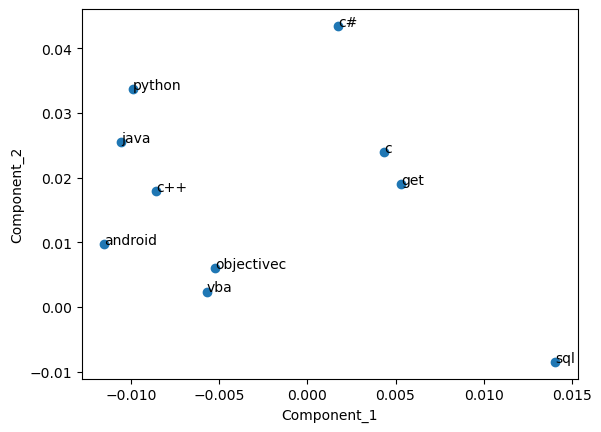

In [392]:
plot_some_data(data_form_pca, ['python','c','c++','c#','objectivec','sql','vba','get','java', 'android'])

<a name="3"></a>
## 3 - Model creation and evaluation

In [400]:
import Binarizer as binar

In [402]:
bnr = binar.Binarizer()
bnr.fit(y_train)
y_train_mat = bnr.transform(y_train)
y_test_mat = bnr.transform(y_test)

In [404]:
import Logistic_Reg as LR

In [472]:
lib = "/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/"

def train_model(model, model_name, x_train, y_train, x_test, resume_training = False):
    if resume_training:
        try:
            all_weights = np.load(lib + 'all_weights_'+ model_name +'.npy',allow_pickle='TRUE').item()
            all_preds = np.load(lib + 'all_preds_'+ model_name +'.npy')
            all_preds_train = np.load(lib + 'all_preds_train_'+ model_name +'.npy')
            starting_point = all_weights['w'].shape[0]
            if starting_point == y_train.shape[1]:
                print("All models trained")
                return all_weights, all_preds

        except (FileNotFoundError, IOError):
            starting_point = 0
    else:
        starting_point = 0

    for i in range(starting_point, y_train.shape[1]):
        model.fit(x_train, y_train[:,i, None],batchsize = 64)
        weights = model.get_param()
        predictions = model.predict_proba(x_test)
        predictions_train = model.predict_proba(x_train)
        if i == 0:
            all_weights = weights
            all_preds = predictions
            all_preds_train = predictions_train
        else:
            all_weights = {key:np.concatenate(([all_weights[key],weights[key]]), axis=0) for key in all_weights.keys()}
            all_preds = np.concatenate((all_preds ,predictions), axis=1)
            all_preds_train = np.concatenate((all_preds_train ,predictions_train), axis=1)
        np.save(lib + 'all_weights_'+ model_name +'.npy', all_weights)
        np.save(lib + 'all_preds_'+ model_name +'.npy', all_preds)
        np.save(lib + 'all_preds_train_'+ model_name +'.npy', all_preds_train)
        print("data stored", i)

    print("All models trained")
    return predictions, all_weights

<a name="3.1"></a>
## 3.1 - BOW model

In [414]:
Log_reg = LR.MyLogisticRegression(learning_rate = 0.01, num_iterations = 50)

In [474]:
model_name = "BOW"
w, p = train_model(Log_reg, model_name, X_train_mybag, y_train_mat, X_test_mybag, resume_training = False)

data stored 0
data stored 1
data stored 2
data stored 3
data stored 4
data stored 5
data stored 6
data stored 7
data stored 8
data stored 9
data stored 10
data stored 11
data stored 12
data stored 13
data stored 14
data stored 15
data stored 16
data stored 17
data stored 18
data stored 19
data stored 20
data stored 21
data stored 22
data stored 23
data stored 24
data stored 25
data stored 26
data stored 27
data stored 28
data stored 29
data stored 30
data stored 31
data stored 32
data stored 33
data stored 34
data stored 35
data stored 36
data stored 37
data stored 38
data stored 39
data stored 40
data stored 41
data stored 42
data stored 43
data stored 44
data stored 45
data stored 46
data stored 47
data stored 48
data stored 49
data stored 50
data stored 51
data stored 52
data stored 53
data stored 54
data stored 55
data stored 56
data stored 57
data stored 58
data stored 59
data stored 60
data stored 61
data stored 62
data stored 63
data stored 64
data stored 65
data stored 66
data 

In [552]:
all_weights = np.load('all_weights_'+ model_name +'.npy',allow_pickle='TRUE').item()
all_preds_test = np.load('all_preds_'+ model_name +'.npy').astype(np.float16)
all_preds_train = np.load('all_preds_train_'+ model_name +'.npy').astype(np.float16)

In [540]:
import Classification_report as CR
rep_BOW = CR.Report()

In [578]:
from importlib import reload
reload(CR)
rep_BOW = CR.Report()

In [514]:
#Finding the optimal threshold based on train data
FPR, TPR, thresh = dict(), dict(), dict()
opt_thresh = []
for i in range(y_train_mat.shape[1]):
    FPR[i], TPR[i], thresh[i] = rep_BOW.calculate_ROC(y_train_mat[:,i], all_preds_train[:,i])
    opt_thresh.append(thresh[i][np.argmax(TPR[i] - FPR[i])])
opt_thresh = np.sum(opt_thresh)/y_train_mat.shape[1]

In [580]:
Y_train_zero_ones = (all_preds_train >= 0.5).astype(int)
rep_BOW.calc_metrics(y_train_mat, Y_train_zero_ones)

               precision   recall   f1-score

    micro avg       0.94      0.27      0.41
    macro avg       0.26      0.07      0.10
    weighted avg    0.69      0.27      0.37



In [582]:
Y_test_zero_ones = (all_preds_test >= 0.5).astype(int)
rep_BOW.calc_metrics(y_test_mat, Y_test_zero_ones)

               precision   recall   f1-score

    micro avg       0.94      0.27      0.42
    macro avg       0.27      0.07      0.10
    weighted avg    0.71      0.27      0.37



In [602]:
def plot_ROC_curve(FPR, TPR, y_data, y_pred):
    n_classes = y_train_mat.shape[1]

    fpr, tpr = dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = rep_BOW.calculate_ROC(y_train_mat[:,i], all_preds_train[:,i])
    fpr["micro"], tpr["micro"], _ = rep_BOW.calculate_ROC(y_data.ravel(), y_pred.ravel())
    roc_auc["micro"] = np.trapz(tpr["micro"], fpr["micro"])

  # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = np.trapz(tpr["macro"], fpr["macro"])
    plt.figure(dpi=100)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink", linestyle=":", linewidth=4,)
    
    plt.plot(fpr["macro"], tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy", linestyle=":", linewidth=4,)
    
    colors = ["aqua", "darkorange"]

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) curve")
    plt.legend()

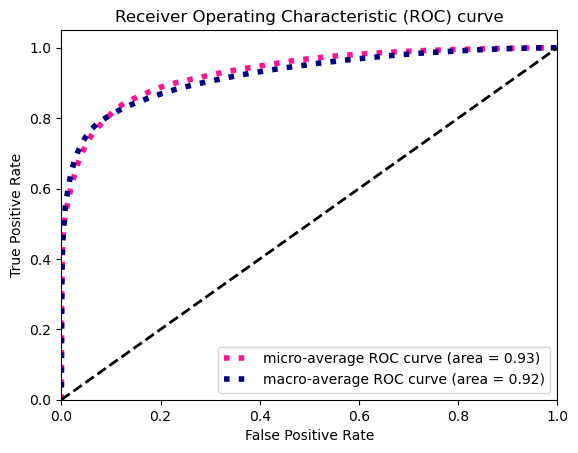

In [604]:
plot_ROC_curve(FPR, TPR, y_test_mat, Y_test_zero_ones)

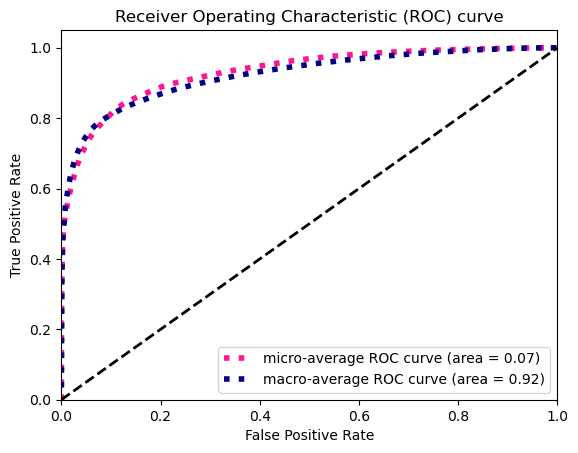

In [600]:
  # Plot all ROC curves
  #plt.figure(figsize=(10,5))
      plt.figure(dpi=100)
      lw = 2
      plt.plot(fpr["micro"], tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink", linestyle=":", linewidth=4,)
    
      plt.plot(fpr["macro"], tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy", linestyle=":", linewidth=4,)
    
      colors = ["aqua", "darkorange"]
      # for i, color in zip(range(n_classes), colors):
      #   plt.plot(fpr[i], tpr[i], color=color, lw=lw,
      #       label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)
    
      plt.plot([0, 1], [0, 1], "k--", lw=lw)
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.title("Receiver Operating Characteristic (ROC) curve")
      plt.legend()

<a name="3.2"></a>
## 3.2 - Tfidf evaluation

In [286]:
Log_reg_tfidf = LR.MyLogisticRegression(learning_rate = 0.01, num_iterations = 50)

(70000,)

In [ ]:
w, p = train_model(Log_reg_tfidf, X_train_mybag, y_train_mat, X_test_mybag, resume_training = False)

<a name="3.3"></a>
## 3.3 - CBOW evaluation

In [83]:
Log_reg_cbow = LR.MyLogisticRegression(learning_rate = 0.01, num_iterations = 50)

(884952, 163224)

In [64]:
w, p = train_model(Log_reg_cbow, X_train_mybag, y_train_mat, X_test_mybag, resume_training = False)

(884952,)